# Working with trajectories: Tips and Tricks

In [37]:
import MDAnalysis as mda
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt

import glob

## Amber AdK trajectory 

Trajectory from a super computer: exists in multiple individual files.

(NOTE: This trajectory is not currently available. I downloaded it from the supercomputer the day before the workshop...)

TOP = "../sandbox/AdK/top/solvated_1ake.top"
TRJ = glob.glob("../sandbox/AdK/md_run1/md_[0-9][0-9][0-9][0-9].nc")

In [34]:
TRJ

['../sandbox/AdK/md_run1/md_0000.nc',
 '../sandbox/AdK/md_run1/md_0001.nc',
 '../sandbox/AdK/md_run1/md_0002.nc']

In [8]:
u = mda.Universe(TOP, TRJ)

In [9]:
u

<Universe with 37081 atoms>

MDAnalysis can read these trajectories with the *ChainReader*: it presents the trajectories as a single contiguous trajectory.

In [10]:
u.trajectory

<ChainReader containing md_0000.nc, md_0001.nc, md_0002.nc with 106220 frames of 37081 atoms>

In [13]:
u.trajectory.totaltime

531095.0

In [14]:
u.trajectory.total_times

array([187390., 196455., 147255.])

In [16]:
u.trajectory.n_frames

106220

In [17]:
u.trajectory.dt

5.0

## In-memory trajectory

- faster analysis
- more convenient for visualization

Use `step=200` i.e., one frame for every 1 ns.

In [19]:
u.transfer_to_memory(step=200, verbose=True)

532/532 frames copied to memory (frame 106200)


In [20]:
u.trajectory

<MemoryReader with 532 frames of 37081 atoms>

In [21]:
u.trajectory.totaltime

531000.0

In [35]:
u.trajectory.n_frames

532

## Visualization

In [24]:
protein = u.select_atoms("protein")

In [26]:
view = nv.show_mdanalysis(protein)
view

NGLWidget(count=532)

Superimpose structures.

In [27]:
from MDAnalysis.analysis import align

In [31]:
aligner = align.AlignTraj(u, u, select="protein and name CA", verbose=True).run()

Step   532/532 [100.0%]


(If `AlignTraj` sees an in-memory trajectory, it will just modify it in place.)

In [33]:
view = nv.show_mdanalysis(protein)
view

NGLWidget(count=532)

## Analysis
Now analyze the trajectory as before!

#### RMSD 

In [38]:
from MDAnalysis.analysis import rms

In [39]:
ca = u.select_atoms("protein and name CA")

R = rms.RMSD(ca)
R.run(verbose=True)

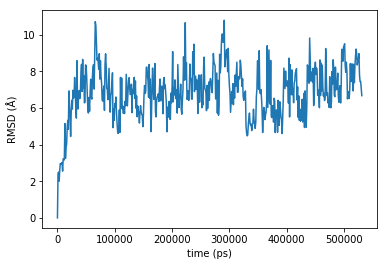

In [40]:
plt.plot(R.rmsd[:, 1], R.rmsd[:, 2])
plt.xlabel("time (ps)")
plt.ylabel("RMSD (Å)");

#### FRET distances 

In [41]:
donors = u.select_atoms("name CB").select_atoms("resname ILE and resid 52", 
                                       "resname ALA and resid 55",
                                       "resname ALA and resid 127")

In [42]:
acceptors = u.select_atoms("name CB").select_atoms("resname LYS and resid 145", 
                                       "resname VAL and resid 169",
                                       "resname ALA and resid 194")

In [44]:
def FRETdist(donors, acceptors):
    return np.linalg.norm(donors.positions - acceptors.positions, axis=1)

In [45]:
distances = []
times = []
for ts in u.trajectory:
    d = FRETdist(donors, acceptors)
    distances.append(d)
    times.append(ts.time)
distances = np.array(distances)
times = np.array(times)

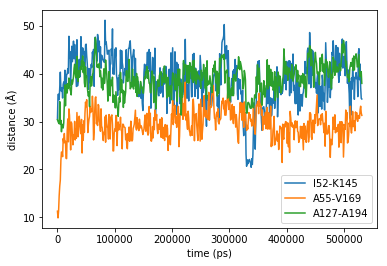

In [46]:
plt.plot(times, distances)
plt.legend(("I52-K145", "A55-V169", "A127-A194"))
plt.xlabel("time (ps)")
plt.ylabel(r"distance (Å)");